## 1. Описание набора данных

В качестве набора данных мы будем использовать набор данных o [медицинской страховке](https://www.kaggle.com/mirichoi0218/insurance).
<a id='data_desc'></a> 

<b>Задача регрессии</b> состоит в предсказании платы за медицинское обслуживание на основании других параметров.

<b>Задача классификации</b> состоит в предсказании того, курит ли пациент или нет, на основании других параметров.

Колонки:

1. `age` - возраст
2. `sex` -  пол
3. `bmi` - индекс массы тела
4. `children` - кол-во детей
5. `smoker` - курит/не курит
6. `region` - регион проживания в США
7. `charges` - плата за мед. обслуживание

### Импорт библиотек

In [241]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score 
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.svm import SVC, NuSVC, LinearSVC, OneClassSVM, SVR, NuSVR, LinearSVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
%matplotlib inline 
sns.set(style="ticks")

In [242]:
# Отрисовка ROC-кривой
def draw_roc_curve(y_true, y_score, pos_label=1, average='micro'):
    fpr, tpr, thresholds = roc_curve(y_true, y_score, 
                                     pos_label=pos_label)
    roc_auc_value = roc_auc_score(y_true, y_score, average=average)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_value)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

### Загрузка данных


In [243]:
data = pd.read_csv('../data/insurance.csv', sep=",")

## 2. Проведение разведочного анализа данных.

### Основные характеристики датасета

In [244]:
# Случайные 5 строк датасета
data.sample(5)

,age,sex,bmi,children,smoker,region,charges
1130,39,female,23.870,5,no,southeast,8582.30230
1217,29,male,37.290,2,no,southeast,4058.11610
986,43,male,30.115,3,no,northwest,8410.04685
556,46,male,33.440,1,no,northeast,8334.58960
652,48,female,31.130,0,no,southeast,8280.62270


In [245]:
# Размер датасета - 1338 строк, 7 колонок
data.shape

(1338, 7)

In [246]:
# Список колониок с типами данных 
data.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [247]:
data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [248]:
# Проверим наличие пустых значений
data.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

####  Представленный набор данных не содержит пропусков.

### Построение графиков
Построим некоторые графики для понимания структуры данных.

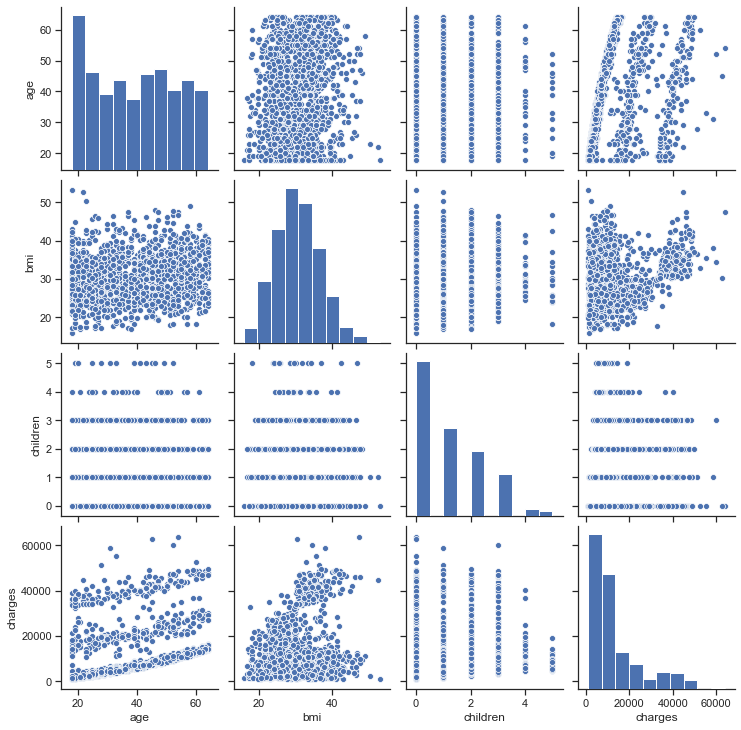

In [249]:
# Парные диаграммы
sns.pairplot(data)

Парные диаграммы. Цветом обозначено курящий человек или нет.

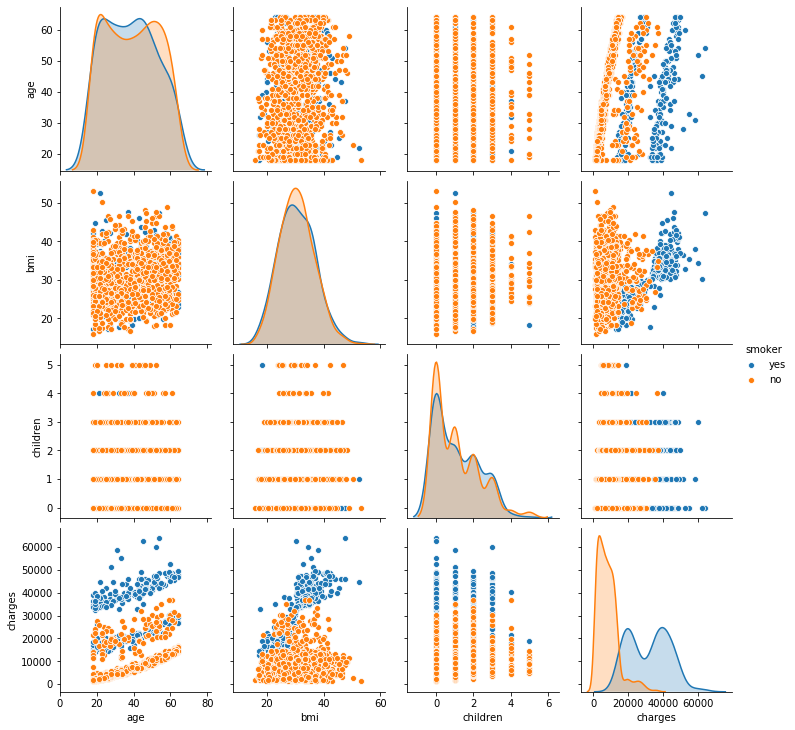

In [10]:
sns.pairplot(data, hue="smoker")

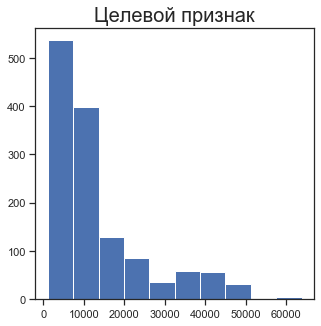

In [252]:
fig, ax = plt.subplots(figsize=(5,5)) 
plt.hist(data['charges'])
plt.title('Целевой признак', fontsize = 20)
plt.show()

Скрипичные диаграммы для числовых колонок:

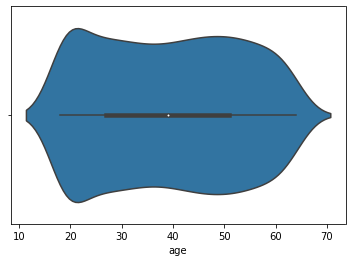

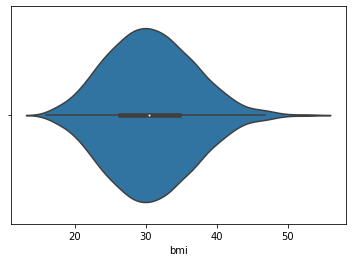

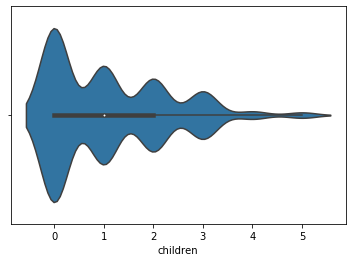

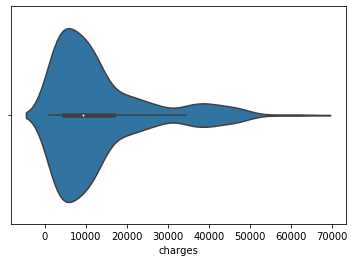

In [15]:
for col in ['age', 'bmi', 'children', 'charges']:
    sns.violinplot(x=data[col])
    plt.show()

## 3. Выбор признаков, подходящих для построения моделей. Кодирование категориальных признаков. Масштабирование данных. Формирование вспомогательных признаков, улучшающих качество моделей.

In [16]:
data.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

Для построения моделей будем использовать все признаки.
Категориальные признаки закодируем с помощью LabelEncoder.

Выполним масштабирование данных. 

In [253]:
le = LabelEncoder()
#пол
le.fit(data.sex.drop_duplicates()) 
data.sex = le.transform(data.sex)
#курение
le.fit(data.smoker.drop_duplicates()) 
data.smoker = le.transform(data.smoker)
#регион
le.fit(data.region.drop_duplicates()) 
data.region = le.transform(data.region)

In [254]:
# Числовые колонки для масштабирования
scale_cols = ['age', 'bmi', 'children']

In [255]:
sc1 = MinMaxScaler()
sc1_data = sc1.fit_transform(data[scale_cols])

In [256]:
# Добавим масштабированные данные в набор данных
for i in range(len(scale_cols)):
    col = scale_cols[i]
    new_col_name = col + '_scaled'
    data[new_col_name] = sc1_data[:,i]

In [257]:
data.head()

,age,sex,bmi,children,smoker,region,charges,age_scaled,bmi_scaled,children_scaled
0,19,0,27.900,0,1,3,16884.92400,0.021739,0.321227,0.0
1,18,1,33.770,1,0,2,1725.55230,0.000000,0.479150,0.2
2,28,1,33.000,3,0,2,4449.46200,0.217391,0.458434,0.6
3,33,1,22.705,0,0,1,21984.47061,0.326087,0.181464,0.0
4,32,1,28.880,0,0,1,3866.85520,0.304348,0.347592,0.0


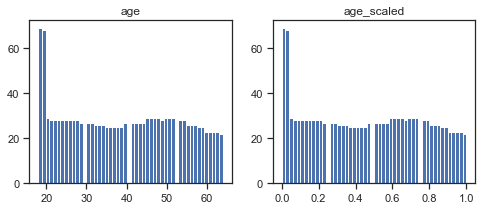

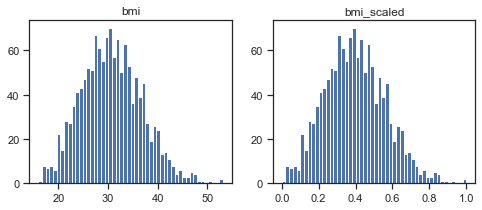

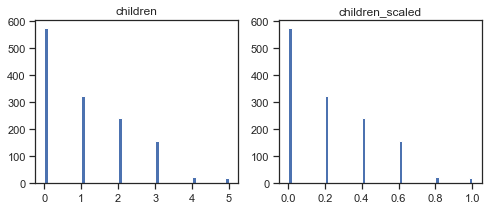

In [258]:
# Проверим, что масштабирование не повлияло на распределение данных
for col in scale_cols:
    col_scaled = col + '_scaled'

    fig, ax = plt.subplots(1, 2, figsize=(8,3))
    ax[0].hist(data[col], 50)
    ax[1].hist(data[col_scaled], 50)
    ax[0].title.set_text(col)
    ax[1].title.set_text(col_scaled)
    plt.show()

Масштабирование не повлияло на распределение данных

## 4. Проведение корреляционного анализа данных. Формирование промежуточных выводов о возможности построения моделей машинного обучения. 

In [259]:
# Воспользуемся наличием тестовых выборок, 
# включив их в корреляционную матрицу
corr_cols_1 = scale_cols + ['charges']
corr_cols_1

['age', 'bmi', 'children', 'charges']

In [260]:
scale_cols_postfix = [x+'_scaled' for x in scale_cols]
corr_cols_2 = scale_cols_postfix + ['charges']
corr_cols_2

['age_scaled', 'bmi_scaled', 'children_scaled', 'charges']

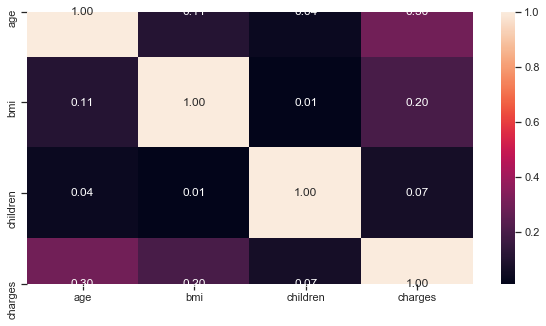

In [261]:
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(data[corr_cols_1].corr(), annot=True, fmt='.2f')

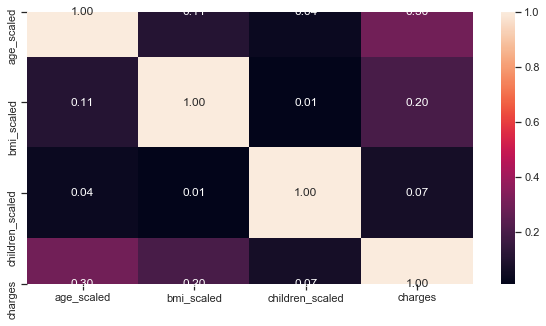

In [262]:
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(data[corr_cols_2].corr(), annot=True, fmt='.2f')

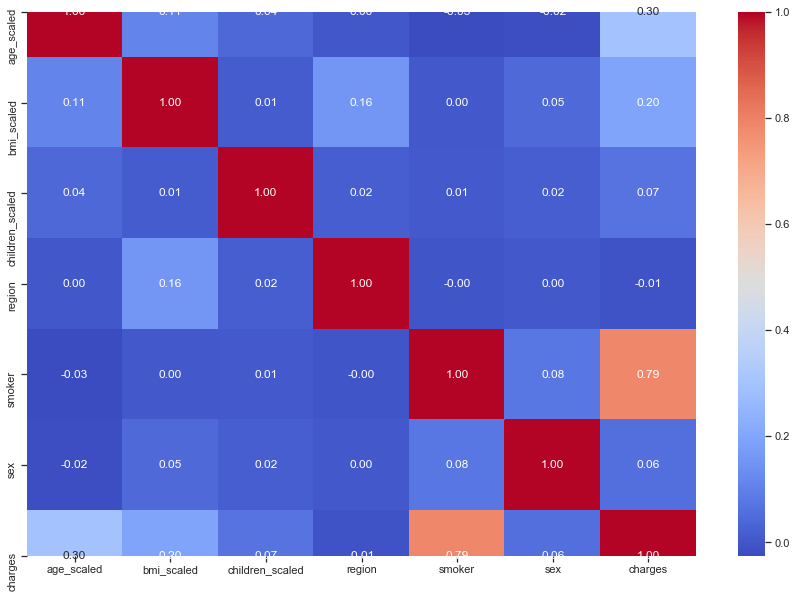

In [263]:
corr_cols_3 = scale_cols_postfix +  ['region', 'smoker', 'sex', 'charges']
plt.figure(figsize = (15,10))
sns.heatmap(data[corr_cols_3].corr(), cmap='coolwarm', annot=True, fmt='.2f')

In [268]:
data.corr()['charges'].sort_values()

region            -0.006208
sex                0.057292
children_scaled    0.067998
children           0.067998
bmi                0.198341
bmi_scaled         0.198341
age                0.299008
age_scaled         0.299008
smoker             0.787251
charges            1.000000
Name: charges, dtype: float64

На основе корреляционной матрицы можно сделать следующие выводы:

- Корреляционные матрицы для исходных и масштабированных данных совпадают.
- Целевой признак `charges` наиболее сильно коррелирует с `smoker` (0.79). Этот признак обязательно следует оставить в модели.
- Все признаки между собой имеют слабую корреляцию. Их можно не удалять.
- Большие по модулю значения коэффициентов корреляции свидетельствуют о значимой корреляции между исходными признаками и целевым признаком.  На основании корреляционной матрицы можно сделать вывод о том, что данные позволяют построить модель машинного обучения. 

## 5. Выбор метрик для последующей оценки качества моделей. 

### 5.1. Метрики для решения задачи классификации:

Метрики, формируемые на основе матрицы ошибок:

#### 1. Метрика precision:

Можно переводить как точность, но такой перевод совпадает с переводом метрики "accuracy".

$precision = \frac{TP}{TP+FP}$

Доля верно предсказанных классификатором положительных объектов, из всех объектов, которые классификатор верно или неверно определил как положительные.

Используется функция [precision_score.](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score)

#### 2. Метрика recall (полнота):

$recall = \frac{TP}{TP+FN}$

Доля верно предсказанных классификатором положительных объектов, из всех действительно положительных объектов.

Используется функция [recall_score.](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score)

#### 3. Метрика $F_1$-мера

Для того, чтобы объединить precision и recall в единую метрику используется $F_\beta$-мера, которая вычисляется как среднее гармоническое от precision и recall:

$F_\beta = (1+\beta^2) \cdot \frac{precision \cdot recall}{precision + recall}$

где $\beta$ определяет вес точности в метрике.

На практике чаще всего используют вариант F1-меры (которую часто называют F-мерой) при $\beta=1$:

$F_1 = 2 \cdot \frac{precision \cdot recall}{precision + recall}$

Для вычисления используется функция [f1_score.](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score)

#### 4. Метрика ROC AUC

Основана на вычислении следующих характеристик:

$TPR = \frac{TP}{TP+FN}$ - True Positive Rate, откладывается по оси ординат. Совпадает с recall.

$FPR = \frac{FP}{FP+TN}$ - False Positive Rate, откладывается по оси абсцисс. Показывает какую долю из объектов отрицательного класса алгоритм предсказал неверно.

Идеальная ROC-кривая проходит через точки (0,0)-(0,1)-(1,1), то есть через верхний левый угол графика.

Чем сильнее отклоняется кривая от верхнего левого угла графика, тем хуже качество классификации.

В качестве количественной метрики используется площадь под кривой - ROC AUC (Area Under the Receiver Operating Characteristic Curve). Чем ниже проходит кривая тем меньше ее площадь и тем хуже качество классификатора.

Для получения ROC AUC используется функция [roc_auc_score.](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score)

### 5.2. Метрики для решения задачи регрессии:

#### 1. [Mean absolute error](https://en.wikipedia.org/wiki/Mean_absolute_error) - средняя абсолютная ошибка

$MAE(y,\hat{y}) = \frac{1}{N} \cdot \sum\limits_{i=1}^N \lvert  y_i - \hat{y_i} \rvert $

где:
- $y$ - истинное значение целевого признака
- $\hat{y}$ - предсказанное значение целевого признака
- $N$ - размер тестовой выборки

Чем ближе значение к нулю, тем лучше качество регрессии.

Основная проблема метрики состоит в том, что она не нормирована.

Вычисляется с помощью функции [mean_absolute_error.](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html#sklearn.metrics.mean_absolute_error)

#### 2. [Mean squared error](https://en.wikipedia.org/wiki/Mean_squared_error) - средняя квадратичная ошибка

$MSE(y,\hat{y}) = \frac{1}{N} \cdot \sum\limits_{i=1}^N ( y_i - \hat{y_i} )^2 $

где:
- $y$ - истинное значение целевого признака
- $\hat{y}$ - предсказанное значение целевого признака
- $N$ - размер тестовой выборки

Вычисляется с помощью функции [mean_squared_error.](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html#sklearn.metrics.mean_squared_error)

#### 3. [Метрика $R^2$ или коэффициент детерминации](https://ru.wikipedia.org/wiki/%D0%9A%D0%BE%D1%8D%D1%84%D1%84%D0%B8%D1%86%D0%B8%D0%B5%D0%BD%D1%82_%D0%B4%D0%B5%D1%82%D0%B5%D1%80%D0%BC%D0%B8%D0%BD%D0%B0%D1%86%D0%B8%D0%B8) 

$R^2(y,\hat{y}) = 1 - \frac{\sum\limits_{i=1}^N ( y_i - \hat{y_i} )^2}{\sum\limits_{i=1}^N ( y_i - \overline{y_i} )^2} $

где:
- $y$ - истинное значение целевого признака
- $\hat{y}$ - предсказанное значение целевого признака
- $N$ - размер тестовой выборки
- $\overline{y_i} = \frac{1}{N} \cdot \sum\limits_{i=1}^N y_i $

Вычисляется с помощью функции [r2_score.](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html#sklearn.metrics.r2_score)

### 5.3. Сохранение и визуализация метрик

Класс, который позволит сохранять метрики качества построенных моделей и реализует визуализацию метрик качества:

In [269]:
class MetricLogger:
    
    def __init__(self):
        self.df = pd.DataFrame(
            {'metric': pd.Series([], dtype='str'),
            'alg': pd.Series([], dtype='str'),
            'value': pd.Series([], dtype='float')})

    def add(self, metric, alg, value):
        """
        Добавление значения
        """
        # Удаление значения если оно уже было ранее добавлено
        self.df.drop(self.df[(self.df['metric']==metric)&(self.df['alg']==alg)].index, inplace = True)
        # Добавление нового значения
        temp = [{'metric':metric, 'alg':alg, 'value':value}]
        self.df = self.df.append(temp, ignore_index=True)

    def get_data_for_metric(self, metric, ascending=True):
        """
        Формирование данных с фильтром по метрике
        """
        temp_data = self.df[self.df['metric']==metric]
        temp_data_2 = temp_data.sort_values(by='value', ascending=ascending)
        return temp_data_2['alg'].values, temp_data_2['value'].values
    
    def plot(self, str_header, metric, ascending=True, figsize=(5, 5)):
        """
        Вывод графика
        """
        array_labels, array_metric = self.get_data_for_metric(metric, ascending)
        fig, ax1 = plt.subplots(figsize=figsize)
        pos = np.arange(len(array_metric))
        rects = ax1.barh(pos, array_metric,
                         align='center',
                         height=0.5, 
                         tick_label=array_labels)
        ax1.set_title(str_header)
        for a,b in zip(pos, array_metric):
            plt.text(0.5, a-0.05, str(round(b,3)), color='white')
        plt.show()    

## 6. Выбор наиболее подходящих моделей для решения задачи классификации или регрессии.

Для задачи регрессии будем использовать следующие модели:
- Линейная регрессия
- Метод ближайших соседей
- Машина опорных векторов
- Решающее дерево
- Случайный лес
- Градиентный бустинг

Для задачи классификации будем использовать следующие модели:
- Логистическая регрессия
- Метод ближайших соседей
- Машина опорных векторов
- Решающее дерево
- Случайный лес
- Градиентный бустинг

## 7. Формирование обучающей и тестовой выборок на основе исходного набора данных.

In [270]:
X_regr = data.drop(['charges'], axis = 1)
Y_regr = data.charges
X_clas = data.drop(['smoker'], axis = 1)
Y_clas = data.smoker
clas_X_train,  clas_X_test,  clas_Y_train,  clas_Y_test = train_test_split(X_clas,  Y_clas, random_state = 42)
regr_X_train,  regr_X_test,  regr_Y_train,  regr_Y_test = train_test_split(X_regr,  Y_regr, random_state = 42)

In [271]:
# Признаки для задачи классификации
task_regr_cols = scale_cols_postfix +  ['region', 'smoker', 'sex']
# Признаки для задачи регресии
task_clas_cols = scale_cols_postfix +  ['region', 'charges', 'sex']

In [272]:
# Выборки для задачи классификации
clas_X_train = clas_X_train[task_clas_cols]
clas_X_test = clas_X_test[task_clas_cols]
clas_X_train.shape, clas_X_test.shape, clas_Y_train.shape, clas_Y_test.shape

((1003, 6), (335, 6), (1003,), (335,))

In [273]:
# Выборки для задачи классификации
regr_X_train = regr_X_train[task_regr_cols]
regr_X_test = regr_X_test[task_regr_cols]
regr_X_train.shape, regr_X_test.shape, regr_Y_train.shape, regr_Y_test.shape

((1003, 6), (335, 6), (1003,), (335,))

## 8. Построение базового решения для выбранных моделей без подбора гиперпараметров.

### 8.1. Решение задачи классификации

In [274]:
# Модели
clas_models = {'LogR': LogisticRegression(), 
               'KNN_5':KNeighborsClassifier(n_neighbors=5),
               'SVC':SVC(),
               'Tree':DecisionTreeClassifier(),
               'RF':RandomForestClassifier(),
               'GB':GradientBoostingClassifier()}

In [275]:
# Сохранение метрик
clasMetricLogger = MetricLogger()

In [276]:
def clas_train_model(model_name, model, clasMetricLogger):
    model.fit(clas_X_train, clas_Y_train)
    Y_pred = model.predict(clas_X_test)
    
    precision = precision_score(clas_Y_test.values, Y_pred)
    recall = recall_score(clas_Y_test.values, Y_pred)
    f1 = f1_score(clas_Y_test.values, Y_pred)
    roc_auc = roc_auc_score(clas_Y_test.values, Y_pred)
    
    clasMetricLogger.add('precision', model_name, precision)
    clasMetricLogger.add('recall', model_name, recall)
    clasMetricLogger.add('f1', model_name, f1)
    clasMetricLogger.add('roc_auc', model_name, roc_auc)

    print('*****************************************************')
    print(model)
    print('*****************************************************')
    draw_roc_curve(clas_Y_test.values, Y_pred)
    
    labels = ['0', '1']
    cm = confusion_matrix(clas_Y_test, Y_pred)
    
    print(cm)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.set(font_scale=1.4) # for label size
    sns.heatmap(cm, annot=True, annot_kws={"size": 16}) # font size
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

C:\Users\volko\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


*****************************************************
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
*****************************************************


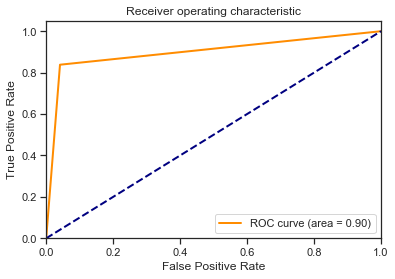

[[256  11]
 [ 11  57]]


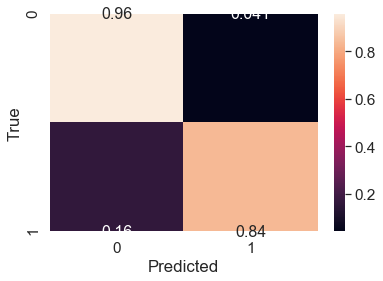

*****************************************************
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
*****************************************************


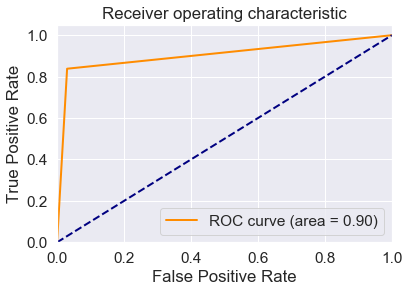

[[259   8]
 [ 11  57]]


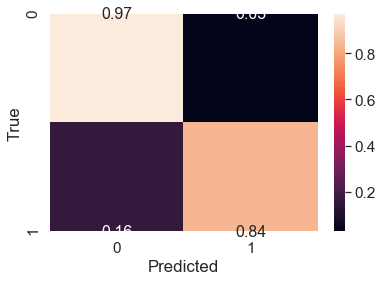

C:\Users\volko\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\volko\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\volko\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


*****************************************************
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
*****************************************************


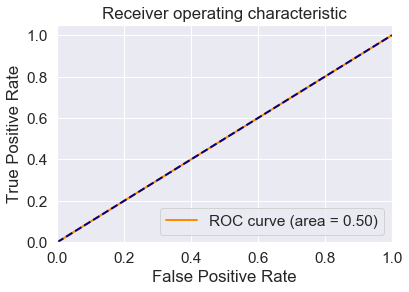

[[267   0]
 [ 68   0]]


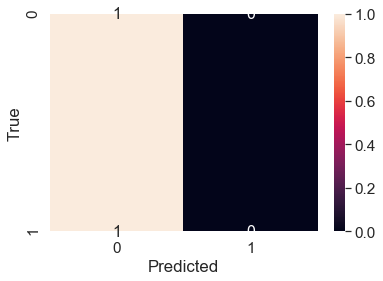

*****************************************************
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
*****************************************************


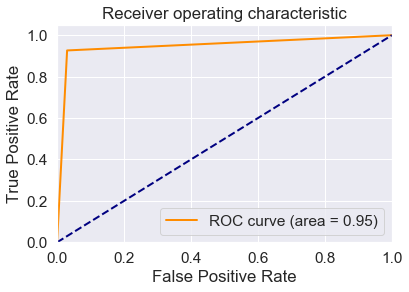

[[259   8]
 [  5  63]]


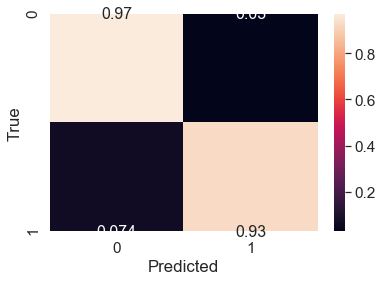

C:\Users\volko\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


*****************************************************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
*****************************************************


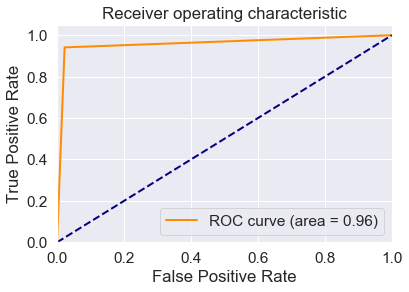

[[261   6]
 [  4  64]]


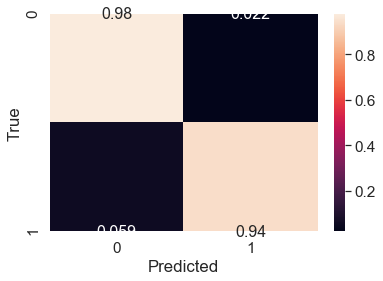

*****************************************************
GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
*****************************************************


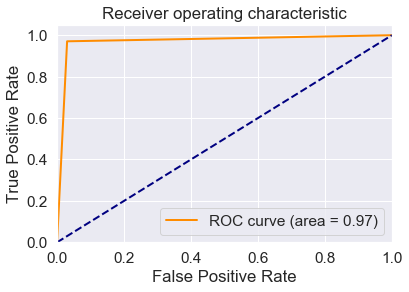

[[259   8]
 [  2  66]]


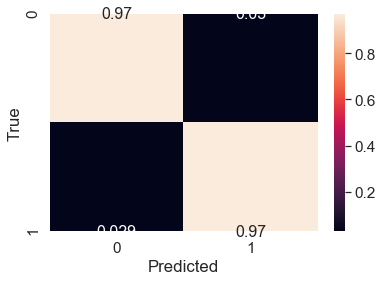

In [277]:
for model_name, model in clas_models.items():
    clas_train_model(model_name, model, clasMetricLogger)

<b>В решении задачи классификации принято решение выбрать метод градиентного бустинга</b>, т.к. на главной диагонали матрицы ошибок он имеет лучшие значения.

### 8.2. Решение задачи регрессии

In [306]:
# Модели
regr_models = {'LR': LinearRegression(), 
               'KNN_5':KNeighborsRegressor(n_neighbors=5),
               'SVR':SVR(),
               'Tree':DecisionTreeRegressor(),
               'RF':RandomForestRegressor(),
               'GB':GradientBoostingRegressor()}

In [307]:
# Сохранение метрик
regrMetricLogger = MetricLogger()

In [308]:
def regr_train_model(model_name, model, regrMetricLogger):
    model.fit(regr_X_train, regr_Y_train)
    Y_pred = model.predict(regr_X_test)
    
    mae = mean_absolute_error(Y_test, Y_pred)
    mse = mean_squared_error(Y_test, Y_pred)
    r2 = r2_score(Y_test, Y_pred)

    regrMetricLogger.add('MAE', model_name, mae)
    regrMetricLogger.add('MSE', model_name, mse)
    regrMetricLogger.add('R2', model_name, r2)    
    
    print('*****************************************************')
    print(model)
    plt.scatter(regr_X_test.age_scaled, regr_Y_test, marker = 's', label = 'Тестовая выборка')
    plt.scatter(regr_X_test.age_scaled, Y_pred, marker = 'o', label = 'Предсказанные данные')
    plt.legend(loc = 'upper left')
    plt.xlabel('Возраст')
    plt.ylabel('Целевой признак')
    plt.show()
    print('MAE={}, MSE={}, R2={}'.format(
        round(mae, 3), round(mse, 3), round(r2, 3)))
    print('*****************************************************')

*****************************************************
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)


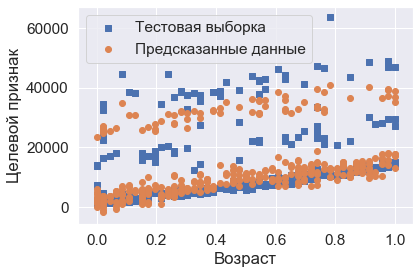

MAE=4252.856, MSE=35174149.327, R2=0.767
*****************************************************
*****************************************************
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')


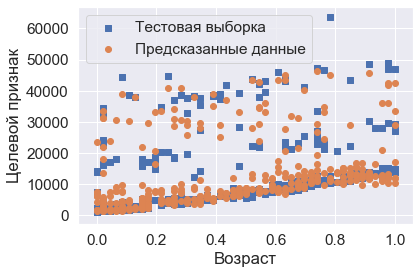

MAE=3570.259, MSE=33099086.69, R2=0.781
*****************************************************
*****************************************************
SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)


C:\Users\volko\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


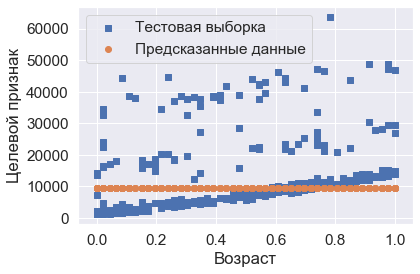

MAE=8494.976, MSE=165259044.005, R2=-0.095
*****************************************************
*****************************************************
DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')


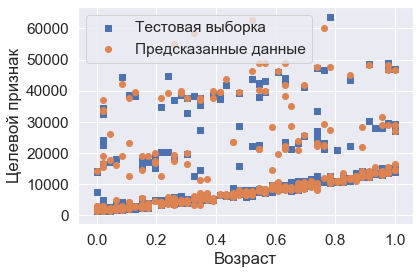

MAE=3054.84, MSE=45578734.864, R2=0.698
*****************************************************
*****************************************************
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)


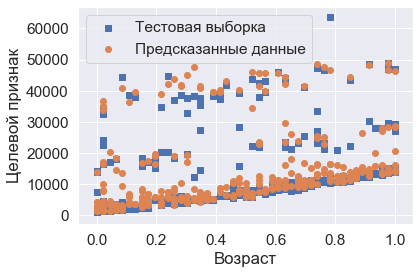

MAE=2539.34, MSE=22175655.634, R2=0.853
*****************************************************
*****************************************************
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


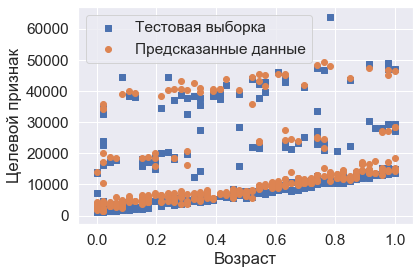

MAE=2553.998, MSE=21065176.145, R2=0.86
*****************************************************


In [327]:
for model_name, model in regr_models.items():
    regr_train_model(model_name, model, regrMetricLogger)

<b>Выберем метод случайного леса.

## 9. Подбор гиперпараметров для выбранных моделей.

### 9.1. Для задачи классификации

Подбор кол-ва деревьев для градиентного бустинга

In [283]:
%%time
params1 = {
    'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 50,
                     75, 100, 200, 300, 400, 500, 600, 700, 800, 900,
                     1000, 1500, 2000]
}

clf_gs = GridSearchCV(estimator=GradientBoostingClassifier(random_state=10),
                    param_grid=params1, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
clf_gs.fit(X_clas, Y_clas)
print('Лучший показатель средней квадратичной ошибки:',-clf_gs.best_score_)
print('Параметры для данного показателя:\n',clf_gs.best_params_)

Лучший показатель средней квадратичной ошибки: 0.0343796711509716
Параметры для данного показателя:
 {'n_estimators': 600}
Wall time: 36.3 s


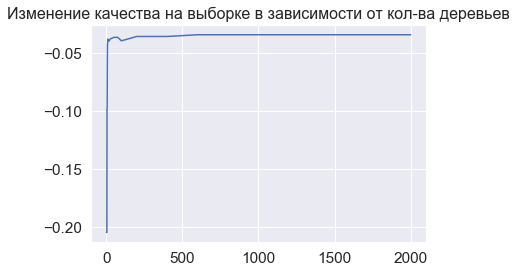

In [286]:
plt.title('Изменение качества на выборке в зависимости от кол-ва деревьев', fontsize = 16)
plt.plot(params1['n_estimators'], clf_gs.cv_results_['mean_test_score'])

### 9.2. Для задачи регрессии

Подбор количества деревьев для метод случайного леса

In [287]:
%%time
regr_gs = GridSearchCV(RandomForestRegressor(), params1, cv=5, scoring='neg_mean_squared_error')
regr_gs.fit(regr_X_train, regr_Y_train)
print('Лучший показатель средней квадратичной ошибки:',-regr_gs.best_score_)
print('Параметры для данного показателя:\n',regr_gs.best_params_)

C:\Users\volko\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Лучший показатель средней квадратичной ошибки: 24765953.322645716
Параметры для данного показателя:
 {'n_estimators': 800}
Wall time: 1min 40s


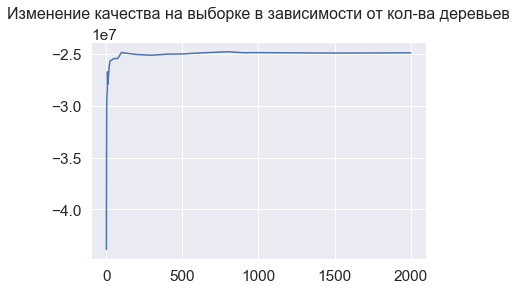

In [289]:
plt.title('Изменение качества на выборке в зависимости от кол-ва деревьев\n', fontsize = 16)
plt.plot(params1['n_estimators'], regr_gs.cv_results_['mean_test_score'])

# 10. Повторение пункта 8 для найденных оптимальных значений гиперпараметров. Сравнение качества полученных моделей с качеством базовых моделей.

### 10.1. Решение задачи классификации

In [290]:
clas_models_grid = {'Grad_600':clf_gs.best_estimator_}

*****************************************************
GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=600,
                           n_iter_no_change=None, presort='auto',
                           random_state=10, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
*****************************************************


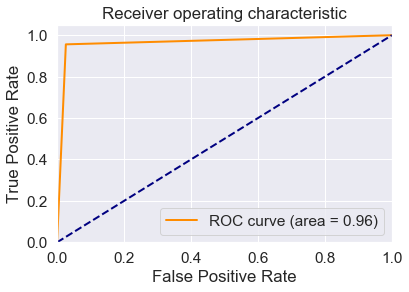

[[260   7]
 [  3  65]]


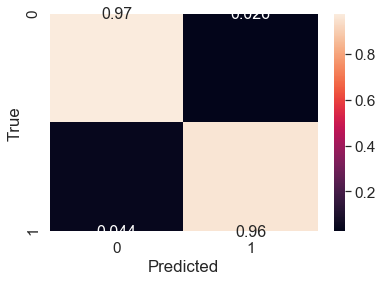

In [291]:
for model_name, model in clas_models_grid.items():
    clas_train_model(model_name, model, clasMetricLogger)

При сравнении матрицы ошибок базовой модели и данной модели видно, что базовая модель обнаружила на одного курильщика больше, но пропустила одного не-курильщика по сравнению  с данной моделью.

### 10.2. Решение задачи регрессии

In [294]:
regr_models_grid = {'Ran_800':regr_gs.best_estimator_}

*****************************************************
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=800,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)


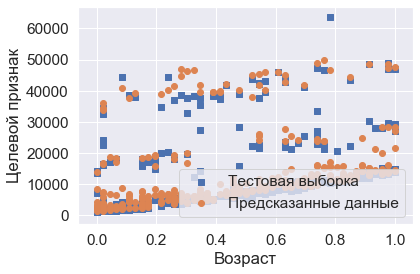

MAE=2568.495, MSE=22501904.071, R2=0.851
*****************************************************


In [295]:
for model_name, model in regr_models_grid.items():
    regr_train_model(model_name, model, regrMetricLogger)

По сравнению с базовой моделью того же метода оценка улучшилась, но оказалась хуже, чем базовая модель градиентного бустинга. Но так получается не каждый раз, зависит от обучающей выборки.

Попробуем повторить модель случайного леса из лабораторной работы № 6, где были получены лучшие показатели.

In [298]:
X1 = data.drop(['charges', 'age_scaled', 'bmi_scaled', 'children_scaled'], axis = 1)
#print(X1)
Y1 = data.charges
#print(Y1)
regr_X_train_not_scaled, regr_X_test_not_scaled, regr_Y_train_not_scaled, regr_Y_test_not_scaled = train_test_split(X1, Y1, random_state = 0)
tree3 = RandomForestRegressor(n_estimators=100, max_features = 0.6, oob_score=True, random_state = 10)
tree3.fit(regr_X_train_not_scaled, regr_Y_train_not_scaled)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=0.6, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=True, random_state=10, verbose=0,
                      warm_start=False)

In [299]:
Y_predicted = tree3.predict(regr_X_test_not_scaled)
print('Средняя абсолютная ошибка:',mean_absolute_error(regr_Y_test_not_scaled, Y_predicted))
print('Средняя квадратичная ошибка:',mean_squared_error(regr_Y_test_not_scaled, Y_predicted))
print('Median absolute error:',median_absolute_error(regr_Y_test_not_scaled, Y_predicted))
print('Коэффициент детерминации:',r2_score(regr_Y_test_not_scaled, Y_predicted))

Средняя абсолютная ошибка: 2620.0107603314173
Средняя квадратичная ошибка: 17924817.459988557
Median absolute error: 1463.2686779999967
Коэффициент детерминации: 0.8861442949055034


Странно, но полученные оценки качества значительно отличаются от полученных в лабораторной работе.

# 11. Формирование выводов о качестве построенных моделей на основе выбранных метрик.

### 11.1. Решение задачи классификации

In [300]:
# Метрики качества модели
clas_metrics = clasMetricLogger.df['metric'].unique()
clas_metrics

array(['precision', 'recall', 'f1', 'roc_auc'], dtype=object)

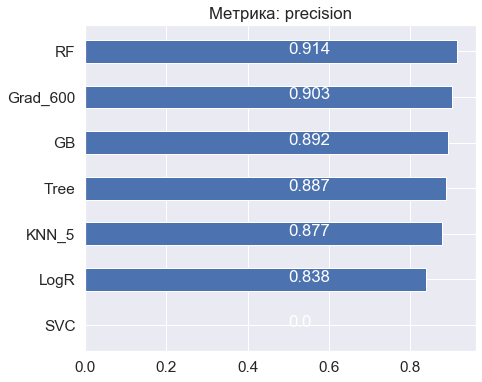

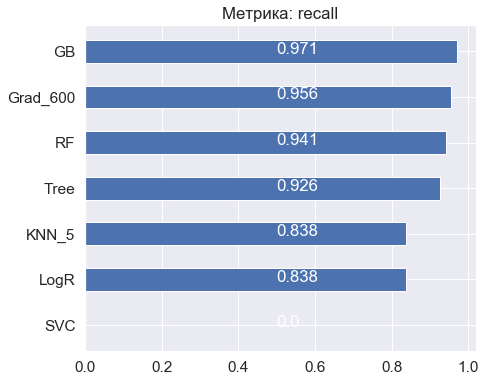

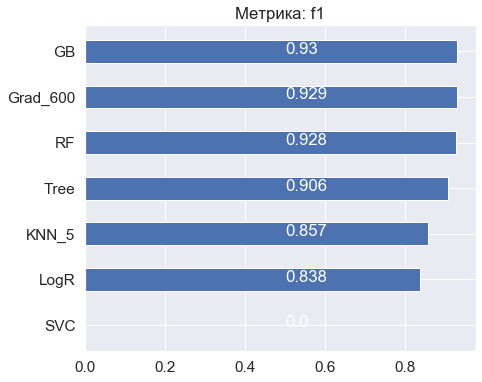

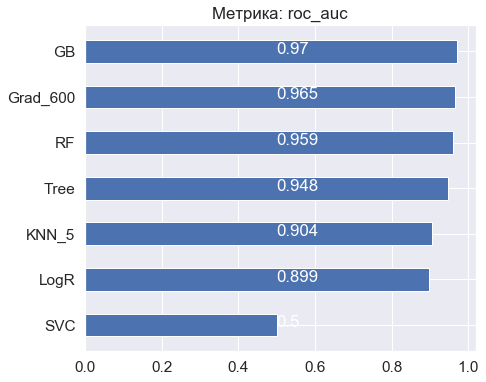

In [301]:
# Построим графики метрик качества модели
for metric in clas_metrics:
    clasMetricLogger.plot('Метрика: ' + metric, metric, figsize=(7, 6))

### Вывод: на основании трех метрик из четырех используемых  лучшей оказалась модель градиентного бустинга.

### 11.2. Решение задачи регрессии

In [302]:
# Метрики качества модели
regr_metrics = regrMetricLogger.df['metric'].unique()
regr_metrics

array(['MAE', 'MSE', 'R2'], dtype=object)

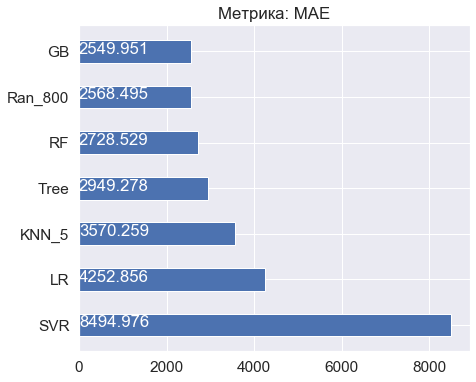

In [303]:
regrMetricLogger.plot('Метрика: ' + 'MAE', 'MAE', ascending=False, figsize=(7, 6))

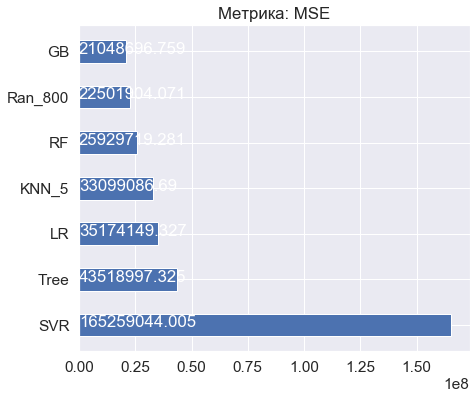

In [304]:
regrMetricLogger.plot('Метрика: ' + 'MSE', 'MSE', ascending=False, figsize=(7, 6), )

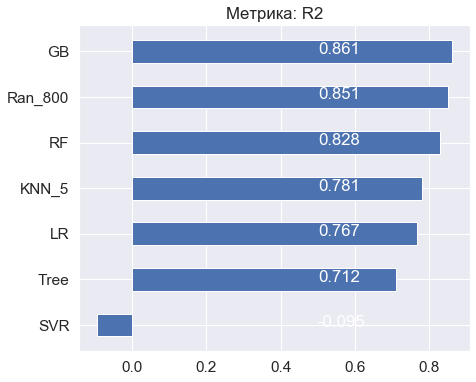

In [305]:
regrMetricLogger.plot('Метрика: ' + 'R2', 'R2', ascending=True, figsize=(7, 6))

### Вывод: лучшими оказались модели на основе градиентного бустинга. При отдельных запусках лучшей оказывается  модель случайного леса.